<h1 style="text-align:center; font-size:30px;">Comprendre les GAN en construisant un générateur d'images de chiens avec TensorFlow et Keras</h1>

<p> Ce tutoriel à pour objectif de montrer les étapes à suivre pour contruire des réseaux de génération adversariels (GAN) qui nous permettra de générer des visages réalistes à partir d'un bruit aléatoire..</p>

## I) Qu'est-ce qu'un GAN?

<p>Les réseaux de génération adversariels (GAN) sont un type de modèle de deep learning qui peuvent générer des images réalistes à partir d'un bruit aléatoire. Leur fonctionnement repose sur un système de compétition entre deux réseaux de neurones : le générateur et le discriminateur.</p>
<p>Le générateur a pour but de créer des images réalistes à partir d'un bruit aléatoire, tandis que le discriminateur a pour but de différencier les images réelles des images générées par le générateur. Les deux réseaux sont entraînés simultanément : le générateur est entraîné pour créer des images qui trompent le discriminateur, tandis que le discriminateur est entraîné pour devenir de plus en plus capable de différencier les images réelles des images générées.</p>
<p>Ainsi, à mesure que le générateur s'améliore pour créer des images plus réalistes, le discriminateur doit s'adapter pour devenir de plus en plus efficace pour les différencier. Le but final est d'obtenir un générateur capable de créer des images aussi réalistes que possible, tout en rendant le discriminateur incapable de les différencier des images réelles.</p>

## II) Construction du GAN

<p> Voici les étapes à suivre pour créer un GAN. On commence d'abord par télécharger le dataset qui contient 200 000 photos de célébrités, disponible à l'adresse suivante : <a href="https://www.kaggle.com/datasets/jessicali9530/celeba-dataset">CelebritéDataSet</a>

#### 0. Téléchargez les librairies nécessaires

In [ ]:
!pip install tensorflow
!pip install keras

#### 1. Importez les bibliothèques nécessaires :

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Activation, UpSampling2D,Dense,Reshape,Dropout,LeakyReLU,Flatten,BatchNormalization,Conv2D,Conv2DTranspose
from tensorflow.keras.models import Sequential

#### 2. Vérifiez si une image  est corrompu

In [ ]:
import os
from tensorflow import image

directory = "./CheminDesPhotos"
files = os.listdir(directory)

for file in files:
    file_path = os.path.join(directory, file)
    try:
        img = image.decode_image(tf.io.read_file(file_path))
    except tf.errors.InvalidArgumentError as e:
        print(f"Erreur à cause de l'image {file_path}: {e}")
        os.remove(os.path.join(file_path))

#### 3. Créez un réseau de génération (Generator) en utilisant la classe Sequential de Keras :

In [2]:
latent_dim = 100

generator = tf.keras.Sequential()

# Input layer
generator.add(layers.Dense(4*4*512, use_bias=False, input_shape=(latent_dim,)))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())
generator.add(layers.Reshape((4, 4, 512)))


generator.add(layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same",
                                 activation="relu"))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same",
                                 activation="relu"))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same",
                                 activation="relu"))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same",
                                 activation="relu"))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())



generator.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              819200    
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        4194816   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 512)        2

#### 4. Créez un réseau de discrimination (Discriminator) en utilisant la classe Sequential de Keras :

In [3]:
discriminator = Sequential()
discriminator.add(Conv2D(512, kernel_size=3, strides=2, padding="same",
                        activation=LeakyReLU(0.3),
                        input_shape=[128, 128, 3]))
discriminator.add(LeakyReLU(alpha=0.01))
discriminator.add(Conv2D(256, kernel_size=4, strides=2, padding="same",
                        activation=LeakyReLU(0.3)))
discriminator.add(LeakyReLU(alpha = 0.01))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same",
                        activation=LeakyReLU(0.3)))
discriminator.add(LeakyReLU(alpha=0.01))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same",
                        activation=LeakyReLU(0.3)))
discriminator.add(LeakyReLU(alpha=0.01))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 512)       14336     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64, 64, 512)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 256)       2097408   
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 32, 32, 256)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       295040    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)         

<p>
    
La première ligne du discriminateur définit la forme d'entrée attendue pour le modèle. Le shape de cette entrée doit être identique au shape des images produites par le générateur, car le discriminateur utilise ces images générées comme entrée pour déterminer si elles sont réelles ou non. Par conséquent, il est nécessaire que le shape de l'entrée du discriminateur soit égal au shape des images produites par le générateur pour que les deux modèles puissent fonctionner ensemble correctement.
    
</p>

#### 5. Définition des fonctions de perte pour GAN:

In [6]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

<p> Ici on définit les fonctions de perte pour le discriminant et pour le générateur dans un modèle GAN. La fonction de perte du discriminant (<code>discriminator_loss</code>) prend en entrée les sorties réelles et fausses du discriminant et calcule la perte en utilisant la fonction de coût <code>BinaryCrossentropy</code>. La fonction de perte du générateur (<code>generator_loss</code>) prend en entrée la sortie fausse du générateur et calcule la perte en utilisant également la fonction de coût <code>BinaryCrossentropy</code>.</p>
<p>Enfin, les deux optimiseurs Adam sont définis pour le générateur et le discriminateur.</p>
<p>Notez que la valeur <code>"from_logits=False"</code> indique que la fonction <code>BinaryCrossentropy</code> s'attend à recevoir des probabilités plutôt que des logits, c'est à dire les sorties activées de la dernière couche du réseau de neurones.</p>

#### 6. Compilations des modèles GAN :

In [7]:
discriminator.compile(optimizer=discriminator_optimizer, loss=tf.keras.losses.binary_crossentropy)
generator.compile(optimizer=generator_optimizer, loss=tf.keras.losses.binary_crossentropy)


<p> Ici on configure les optimiseurs et les fonctions de perte pour le discriminant et le générateur.</p>
<p>Avec <code>discriminator.compile(optimizer=discriminator_optimizer, loss=tf.keras.losses.binary_crossentropy)</code>, on défini l'optimiseur <code>discriminator_optimizer</code> pour le modèle du discriminateur et la fonction de perte <code>tf.keras.losses.binary_crossentropy</code> qui calcule la différence entre les valeurs prédites et les valeurs cibles.</p>
<p>De même, avec <code>generator.compile(optimizer=generator_optimizer, loss=tf.keras.losses.binary_crossentropy)</code> on défini l'optimiseur <code>generator_optimizer</

#### 7. Fonction d'entraînement pour GAN

In [8]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss


<p>1. <code>noise = tf.random.normal([BATCH_SIZE, 100])</code> : Cette ligne crée une variable "noise" qui est un tableau de taille BATCH_SIZE x 100 rempli de nombres aléatoires suivant une distribution normale.</p>

<p>2. <code>with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: </code> : Cette ligne démarre deux contextes de "GradientTape", un pour l'optimiseur du générateur et un pour l'optimiseur du discriminateur. Cela permettra de calculer les gradients pour chacun d'entre eux.</p>

<p>3. <code>generated_images = generator(noise, training=True)</code> : Cette ligne utilise la fonction générateur pour générer des images à partir de la variable "noise" créée précédemment, avec le mode "training"activé.</p>

<p>4. <code>real_output = discriminator(images, training=True)</code> : Cette ligne utilise la fonction discriminateur pour évaluer les images réelles avec le mode "training"activé.</p>

<p>5. <code>fake_output = discriminator(generated_images, training=True)</code>: Cette ligne utilise la fonction discriminateur pour évaluer les images générées.</p>

<p>6. <code>gen_loss = generator_loss(fake_output) </code> : Cette ligne utilise la fonction de perte du générateur pour calculer la perte en utilisant les résultats de la fonction discriminateur pour les images générées.</p>


<p>7. <code> disc_loss = discriminator_loss(real_output, fake_output)</code> : Cette ligne utilise la fonction de perte du discriminateur pour calculer la perte en utilisant les résultats de la fonction discriminateur pour les images réelles et les images générées.</p>

<p>8. <code>gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)</code> : Cette ligne calcule les gradients pour les variables entraînables du générateur en utilisant la perte du générateur et les informations enregistrées dans le contexte de "gen_tape".</p>


<p>9. <code>gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)</code>: Cette ligne calcule les gradients pour les variables entraînables du discriminateur en utilisant la perte du discriminateur et les informations enregistrées dans le contexte de "disc_tape".</p>

<p>10. <code>generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))</code> : Cette ligne utilise l'optimiseur du générateur pour mettre à jour les variables entraînables en utilisant les gradients calculés précédemment.</p>

<p>11. <code>discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))</code> : Cette ligne utilise l'optimiseur du discriminateur pour mettre à jour les variables entraînables en utilisant les gradients calculés précédemment.</p>

<p>12. <code>return gen_loss, disc_loss </code> : Cette ligne retourne les valeurs de perte du générateur et du discriminateur pour cette étape d'entraînement. </p>

#### 8. On charge notre jeu de données d'images en utilisant la classe ImageDataGenerator de Keras :

In [ ]:
batch_size = 8
data_gen =  keras.preprocessing.image_dataset_from_directory(
    directory="./CheminImages", label_mode=None,color_mode='rgb', image_size=(128, 128), batch_size=batch_size
).map(lambda x: x / 255.0)

#### 9. Entraînez le modèle GAN en utilisant une boucle for pour itérer sur chaque époque :

In [ ]:
gen_losses = []
disc_losses = []

EPOCHS = 2000


for epoch in range(EPOCHS):
    print("Nous sommes à l'épooch:", epoch)
    for images in tqdm(data_gen):
        gen_loss, disc_loss = train_step(images)
    gen_losses.append(gen_loss)
    disc_losses.append(disc_loss)
    print ("epoch:",epoch,"gen_loss:",gen_loss,"disc_loss:",disc_loss)
  

    
    

    generated_image = generator(tf.random.normal([1, 100]), training=False)
    generated_image = (generated_image + 1) * 0.5
   
    import matplotlib.pyplot as plt
    plt.imshow(generated_image[0])
    plt.show()
    
    if epoch%50 == 0:
        generator.save("./Models/"+str(epoch)+"generator.h5")
        discriminator.save("./Models/"+str(epoch)+"discriminator.h5")
        generator.save_weights("./Models/generator_weights_epoch_{}.h5".format(epoch))
        discriminator.save_weights("./Models/discrminator_weights_epoch_{}.h5".format(epoch))

#### 10. On peut maintenant utiliser le réseau generator pour générer des images en utilisant une entrée aléatoire :

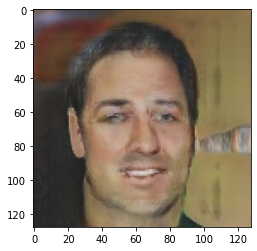

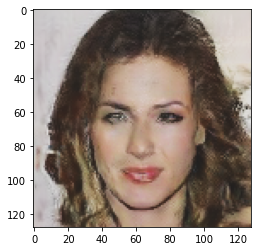

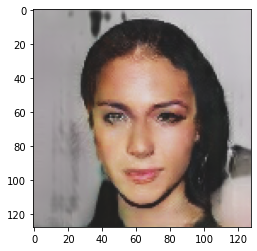

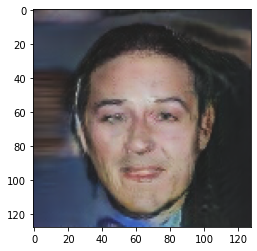

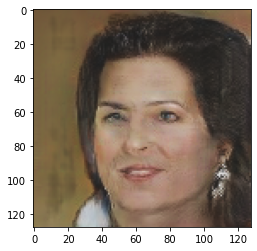

In [15]:
for i in range(5):
    generated_image = generator(tf.random.normal([1, 100]), training=False)
    generated_image = (generated_image + 1) * 0.5
    import matplotlib.pyplot as plt
    plt.imshow(generated_image[0])
    plt.show()

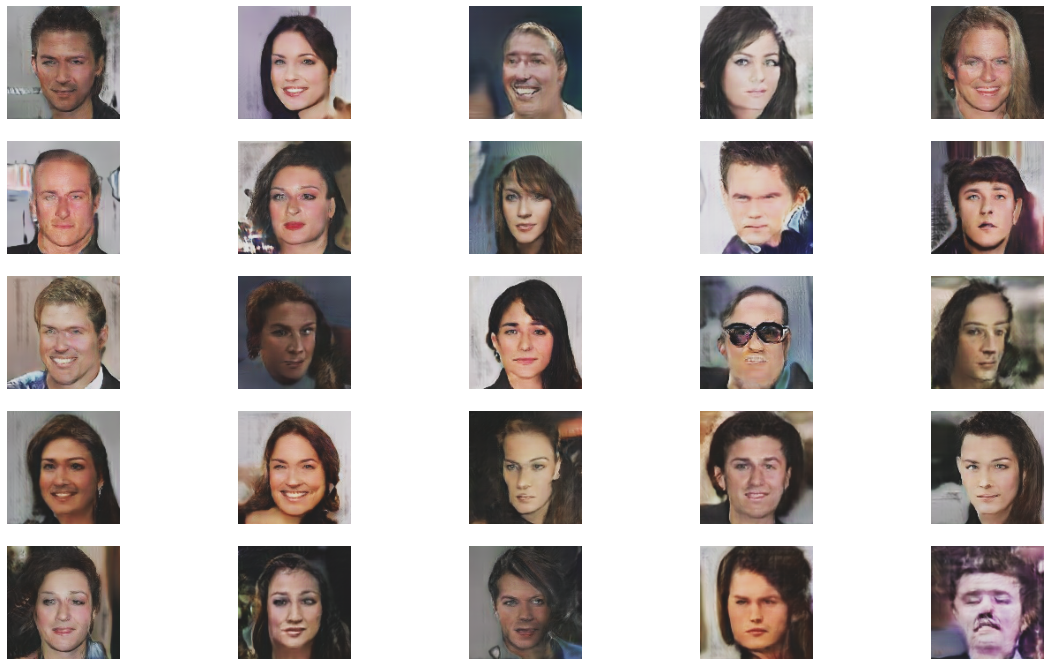

In [18]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20,12))
axes = axes.ravel()

for i in range(25):
    generated_image = generator(tf.random.normal([1, 100]), training=False)
    generated_image = (generated_image + 1) * 0.5
    axes[i].imshow(generated_image[0])
    axes[i].axis('off')

plt.show()
